### 06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
#### 1) 규제 선형 모델의 개요

- 회귀모델은 적절히 데이터에 적합하면서도 회귀계수가 기하급수적으로 커지는 것을 제어할 수 있어야 함
- 이전까지 선형 모델은 비용함수인 RSS를 최소화하는 것만을 고려해 학습 데이터에 지나치게 맞추게 되고, 회귀계수가 쉽게 커짐
 - 변동성이 오히려 심해져서 테스트 데이터 세트에서는 예측 성능이 저하되기 쉬움
 - RSS 최소화 방법과 과적합을 방지하는 방법이 서로 균형을 이뤄야 함
- 비용 함수 목표 = $Min ( RSS(W) + alpha* ||W||^2_2)$
 - alpha : 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터
alpha가 0(또는 매우 작은 값)이라면 비용함수 식은 기존과 동일한 Min ( RSS(W) + 0), alpha가 무한대(또는 매우 큰 값)라면 비용 함수 식은 RSS(W)에 비해 $alpha*||W||^2_2$ 값이 너무 커지게 되므로 W값을 0(또는 매우 작게)으로 만들어야 Cost가 최소화되는 비용 함수 목표 달성 가능
 - alpha값을 크게 하면 비용함수는 회귀 계수 W의 값을 작게 해 과적합을 개선, alpha값을 작게 하면 회귀 계수 W의 값이 커져도 어느정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선 가능
- 이처럼 alpha 값으로 비용 함수에 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 **규제(Regularization)** 라고 함
1. L2 규제 : $alpha*||W||^2_2$와 같이 W의 제곱에 대해 페널티를 부여하는 방식. 이를 적용한 회귀는 **릿지(Ridge)** 회귀
2. L1 규제 : $alpha*||W||_1$와 같이 W의 절댓값에 대해 페널티를 부여하는 방식. 이를 적용한 회귀는 **라쏘(Lasso)** 회귀로 영향력이 크지 않은 회귀 계수 값을 0으로 변환

#### 2) 릿지 회귀
- 사이킷런은 Ridge 클래스를 통해 릿지 회귀 구현
 - 주요 생성 파라미터는 alpha

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# 보스턴 주택 가격 예제 이용
from sklearn.datasets import load_boston
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함
bostonDF['PRICE']=boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace = False)

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 3))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores :  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


- 릿지의 5개 폴드 세트의 평균 RMSE는 5.518로 앞에서 학습한 규제가 없는 LinearRegression의 평균 RMSE 값인 5.829보다 작음. 더 뛰어난 예측 성능

In [3]:
# alpha값을 0, 0.1, 1, 10, 100 으로 변경하면서 RMSE 측정

# Ridge에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구함
for alpha in alphas :
    ridge = Ridge(alpha = alpha)

    # cross_val_score를 이용하여 5 fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha,avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds의 평균 RMSE : 5.330 


- alpha가 100일 때, 평균 RMSE가 5.330으로 가장 작음

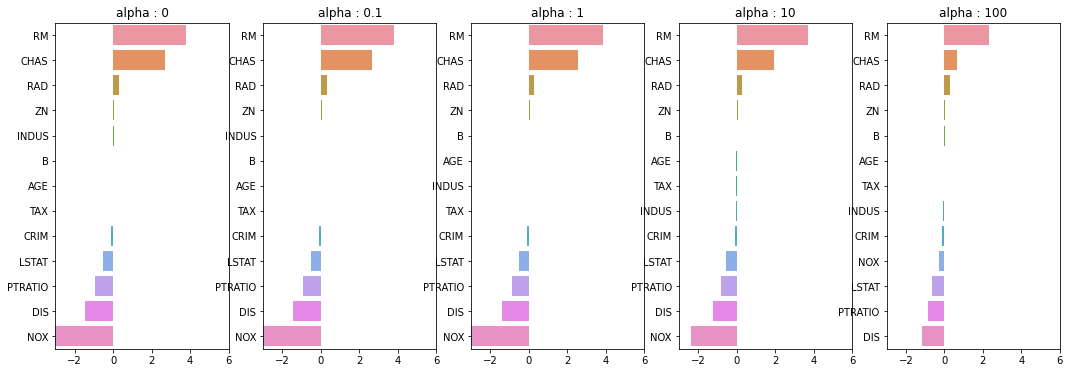

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 각 alpha에 따른 Feature의 회귀 계수 값을 가로 막대 그래프로 시각화
# 5개의 열로 된 matplotlib 축 생성  
fig, axs = plt.subplots(figsize = (18 ,6) , nrows = 1 , ncols = 5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    # alpha에 따른 Feature 별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가 
    coeff = pd.Series(data = ridge.coef_, index = X_data.columns )
    colname = 'alpha : '+str(alpha)
    coeff_df[colname] = coeff
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending = False) 
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3 ,6)
    sns.barplot(x = coeff.values , y = coeff.index, ax = axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 화귀계수를 DataFrame으로 표시
plt.show()

- alpha 값을 증가시킬수록 회귀 계수 값이 작아짐
- 특히 Nox Feature의 경우, alpha 값을 증가시킴에 따라 회귀 계수가 눈에 띄게 작아짐

In [7]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha : ' + str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending = False)

,alpha : 0,alpha : 0.1,alpha : 1,alpha : 10,alpha : 100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


- alpha 값을 증가시킬수록 회귀 계수가 지속적으로 작아짐
- 릿지 회귀의 경우 회귀계수를 0으로 만들지는 않음

#### 3) 라쏘 회귀
- W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것이 라쏘(Lasso) 회귀
- L1 규제는 $alpha*||W||_1$를 의미하며, 라쏘 회귀 비용 함수의 목표는 RSS(W)+$alpha*||W||_1$를 최소화하는 W를 찾는 것
- L2 규제는 회귀 계수의 크기를 감소시키는 반면, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거 
 - =>  L1 규제는 적절한 Feature만 회귀에 포함시키는 Feature 선택을 수행
- 사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현
 - Lasso 클래스의 주요 생성 파라미터는 alpha

In [22]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환 
from sklearn.linear_model import Lasso, ElasticNet
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True):
    coeff_df = pd.DataFrame()
    if verbose : print("#######", model_name, "#######")
    for param in params:
        if model_name == "Ridge" : model = Ridge(alpha=param)
        elif model_name == "Lasso" : model = Lasso(alpha=param)
        elif model_name == "ElasticNet" : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
        mse_scores = -1 * neg_mse_scores
        rmse_scores = np.sqrt(mse_scores)
        avg_rmse = np.mean(rmse_scores)
        print("alpha {0} 일 때, 5 folds 의 평균 RMSE: {1:.3f}".format(param, avg_rmse))

        # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수를 추출
        model.fit(X_data, y_target)
        
        # alpha에 따른 피처별 회귀 계수를 Series로변환하고 이를 DataFrame의 칼럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = "alpha" + str(param)
        coeff_df[colname] = coeff

    return coeff_df

In [9]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

#######  Lasso #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189 


- lpha가 0.07 일 때, 평균 RMSE 값이 가장 작음
- 릿지 회귀에서의 평균 RMSE 값인 5.330보다는 크지만, 규제가 없는 LinearRegression의 평균 RMSE 값인 5.829보다는 작음

In [10]:
# 반환된 coeff_lasso_df를 첫번째 Column 순으로 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha : ' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- alpha의 크기가 증가함에 따라 일부 Feature의 회귀 계수가 아예 0으로 바뀜
- NOX 속성은 alpha가 0.07일 때부터 회귀 계수가 0이며, alpha가 증가하면서 INDUS, CHAS와 같은 Feature의 회귀 계수가 0으로 바뀜
 - 회귀 계수가 0인 Feature는 회귀 식에서 제외되면서, Feature 선택의 효과
 
#### 4) 엘라스틱넷 회귀
- 엘라스틱넷(Elastic Net) 회귀는 L2 규제와 L1 규제를 결합한 회귀
- $RSS(W) + alpha2*||W||^2_2 + alpha1*||W||_1)$ 식을 최소화하는 W를 찾고자 함
- 라쏘 회귀는 서로 상관관계가 높은 Feature들의 경우, 이들 중 중요한 Feature만을 선택하고, 다른 Feature들은 회귀 계수를 모두 0으로 만들기에 alpha 값에 따라 회귀 계수의 값이 급격하게 변할 수 있음 => 이를 완화하기 위해 라쏘 회귀에 L2 규제 추가
- 단) L1과 L2를 결합하여 규제를 적용하기 때문에, 수행시간이 상대적으로 오래 걸림
- 사이킷런은 ElasticNet 클래스를 통해 엘라스틱넷 회귀를 구현
 - ElasticNet 클래스의 주요 생성 파라미터는 alpha와 l1_ratio이다.
 - 엘라스틱넷의 규제는 $a*L1 + b*L2$로 정의됨. 이때 a는 L1 규제의 alpha값, b는 L2 규제의 alpha 값
 - l1_ratio 파라미터 값은 a/(a+b). l1_ratio가 0이면 L2규제와 동일, l1_ratio가 1이면 L1 규제와 동일

In [12]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [ 0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

#######  ElasticNet #######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542 
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526 
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467 
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597 
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068 


In [13]:
# 반환된 coeff_elastic_df를 내림차순 정렬하여 회귀계수 DataFrame 출력
sort_column = 'alpha : ' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha : 0.07,alpha : 0.1,alpha : 0.5,alpha : 1,alpha : 3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- alpha가 0.5일 때, RMSE가 5.467로 가장 좋은 예측 성능
- Feature들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적dma

1. 규제선형회귀의 기법중 어떤것이 가장 좋은지는 상황에 따라 다름
2. 각각의 알고리즘에서 하이퍼파라미터를 변경해가며 최적의 예측 성능을 찾아야 함.
3. 선형 회귀의 경우 최적의 하이퍼 파라미터를 찾아내는 것 못지않게 데이터분포도의 정규화와 인코딩 방법이 매우 중요

#### 5) 선형 회귀 모델을 위한 데이터 변환

- 선형 회귀 모델과 같은 선형 모델은 일반적으로 Feature와 Target 값 간에 선형의 관계가 있다고 가정하고, 데이터들을 가장 잘 표현하는 최적의 선형 함수를 찾아, 결과값을 예측
- 선형 회귀 모델은 Feature와 Target 값의 분포로 정규 분포를 선호.
- 특히 타깃값의 경우, 특정 값으로 치우친 왜곡(Skew)된 형태의 분포도일 경우, 예측 성능에 부정적인 영향을 미칠 가능성이 높음
 - 피처값 역시 Target 값보다는 덜하지만, 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있음
 - 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터를 스케일링하거나 정규화하는 것이 일반적
- 일반적으로 중요 피처들이나 타깃값의 분포가 심하게 왜곡되었을 때, 이러한 변환 작업을 수행

1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터셋으로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고, 최댓값이 1인 값으로 정규화를 수행
2. 스케일링/정규화를 수행한 데이터셋에 다시 다항 특성을 적용하여 변환. 보통 1번을 적용했는데도, 예측 성능이 향상되지 않을 경우 이와 같은 방법을 적용
3. 원래 값에 log 함수를 적용하면 정규 분포에 가까운 형태로 값이 분포됨. 이러한 변환을 **로그 변환(Log Transformation)** 이라고 부름. 1번 방법은 예측 성능이 크게 향상되기 힘들고, 2번 방법은 피처의 개수가 많을 경우 과적합 이슈가 발생할 수 있기 때문에 실제로 로그 변환이 1, 2번 방법보다 자주 사용됨

- 타깃값의 경우 일반적으로 로그 변환 적용
 - 정규 분포나 다른 값으로 변환하면 변환된 값을 다시 원본 값으로 복원하기 어려움

In [25]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다향식 특성을 추가할 때 적용. p_degree는 2이상 부여하지 않음. 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method = 'None', p_degree = None, input_data = None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
    return scaled_data

In [27]:
# Ridge의 alpha 값을 다르게 적용하고, 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규분포, 표준정규분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그 변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), 
                ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = X_data)
    print('\n## 변환 유형: {0}, Polynomial Degree: {1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params = alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose = False)


## 변환 유형: None, Polynomial Degree: None
alpha 0.1 일 때, 5 folds 의 평균 RMSE: 5.788
alpha 1 일 때, 5 folds 의 평균 RMSE: 5.653
alpha 10 일 때, 5 folds 의 평균 RMSE: 5.518
alpha 100 일 때, 5 folds 의 평균 RMSE: 5.330

## 변환 유형: Standard, Polynomial Degree: None
alpha 0.1 일 때, 5 folds 의 평균 RMSE: 5.826
alpha 1 일 때, 5 folds 의 평균 RMSE: 5.803
alpha 10 일 때, 5 folds 의 평균 RMSE: 5.637
alpha 100 일 때, 5 folds 의 평균 RMSE: 5.421

## 변환 유형: Standard, Polynomial Degree: 2
alpha 0.1 일 때, 5 folds 의 평균 RMSE: 8.827
alpha 1 일 때, 5 folds 의 평균 RMSE: 6.871
alpha 10 일 때, 5 folds 의 평균 RMSE: 5.485
alpha 100 일 때, 5 folds 의 평균 RMSE: 4.634

## 변환 유형: MinMax, Polynomial Degree: None
alpha 0.1 일 때, 5 folds 의 평균 RMSE: 5.764
alpha 1 일 때, 5 folds 의 평균 RMSE: 5.465
alpha 10 일 때, 5 folds 의 평균 RMSE: 5.754
alpha 100 일 때, 5 folds 의 평균 RMSE: 7.635

## 변환 유형: MinMax, Polynomial Degree: 2
alpha 0.1 일 때, 5 folds 의 평균 RMSE: 5.298
alpha 1 일 때, 5 folds 의 평균 RMSE: 4.323
alpha 10 일 때, 5 folds 의 평균 RMSE: 5.185
alpha 100 일 때, 5 folds 의 평균 RMSE: 6.538

## 

- 표준 정규 분포나 최솟값/최댓값 정규화로 Feature 데이터셋을 변경해도 성능 상의 개선은 없음
- 다항식 변환은 Feature 개수가 많을 경우 과적합 때문에 적용하기 힘들며, 계산에 많은 시간이 소모되어 한계가 있음
- 로그 변환 결과를 보면 alpha가 0.1, 1, 10일 때, 성능이 개선

### 07 로지스틱 회귀
- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘
- 로지스틱 역시 가중치 변수(weight)가 선형이기 때문에, 선형 회귀 계열에 속함
- 로지스틱 회귀는 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid) 함수 최적선을 찾고, 이 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정
- 시그모이드 함수 : 1/(1+exp(-x))
 - x 값이 무한대로 가더라도, y 값은 항상 0과 1 사이의 값을 반환
 - x 값이 커지면 1에 근사하고, x 값이 작아지면 0에 근사
 - x = 0일 때, 함수값은 0.5

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size = 0.3, random_state = 0)

In [30]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용해 학습 및 예측 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

# 정확도와 roc_auc 측정
print('accuracy : {:0.3f}'.format(accuracy_score(y_test, lr_preds)))
print('roc_auc : {:0.3f}'.format(roc_auc_score(y_test , lr_preds)))

accuracy : 0.977
roc_auc : 0.972


- 사이킷런 LogisticRegression 클래스의 주요 하이퍼 파라미터들
1. penalty : 규제(Regularization)의 유형을 설정한다. 'l2'이면, L2 규제를, 'l1'이면 L1 규제를 적용. 디폴트는 'l2'
2. C : 1/alpha. C값이 작을수록 규제 강도가 큼

In [35]:
# 하이퍼파라미터 최적화
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

params={'penalty':['l2', 'l1'],
        'C':[0.01, 0.1, 1, 1, 5, 10]}

grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring = 'accuracy', cv = 3 )
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 1, 'penalty': 'l2'}, 최적 평균 정확도:0.975


- 로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 좋음
- 로지스틱 회귀는 희소한 데이터셋 분류에서도 뛰어난 성능을 보이며, 텍스트 분류에서도 자주 사용됨

### 08 회귀 트리
- 비선형 회귀 역시 비선형 회귀 함수를 통해 결과값을 예측, 다만 회귀 계수의 결합이 비선형이라는 차이
- 머신러닝에서 회귀는 회귀 계수를 기반으로 하는 최적 회귀 함수를 도출하는 것이 주요 목표이다.

- 트리 기반의 회귀 : 회귀를 위한 트리를 생성하고, 이를 기반으로 회귀 예측을 한다.
 - 분류 트리는 특정 클래스 레이블을 결정하지만, 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산
 - CART(Classification And Regression Tree)는 분류뿐만 아니라 회귀도 가능한 트리 생성 알고리즘. 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 모든 트리 기반 알고리즘은 회귀도 가능

In [36]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


In [37]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('##### ', model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행 
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.251 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


<AxesSubplot:>

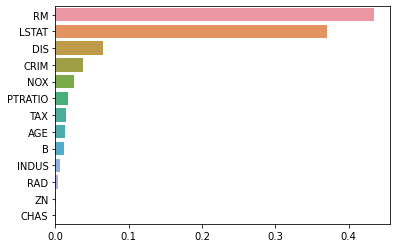

In [39]:
# 회귀 트리 클래스는 회귀계수를 제공하는 coef_ 속성이 없고 feature_importances_를 이용해 피처별 중요도 시각화 가능

import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞에서 만들어진 X_data, y_target 데이터셋을 적용해 학습  
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns )
feature_series = feature_series.sort_values(ascending = False) # 내림차순
sns.barplot(x = feature_series, y = feature_series.index)

(100, 2)


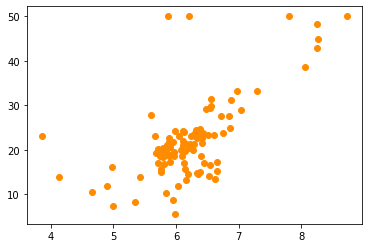

In [40]:
# 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교화 시각화
## 하이퍼파라미터 max_depth 크기를 변화시키며 회귀 트리 예측선이 어떻게 변화하는지 파악
# Price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만 이용해 선형 회귀와 결정 트리 회귀로  PRICE 예측 회귀선 표현

# 보스턴 데이터 세트의 개수를 100개만 샘플리해 RM, PRICE 칼럼만 추출
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample( n =100, random_state = 0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")

In [42]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측을 적용할 테스트용 데이터 셋을 4.5 ~ 8.5 까지 100개 테스트 데이터세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

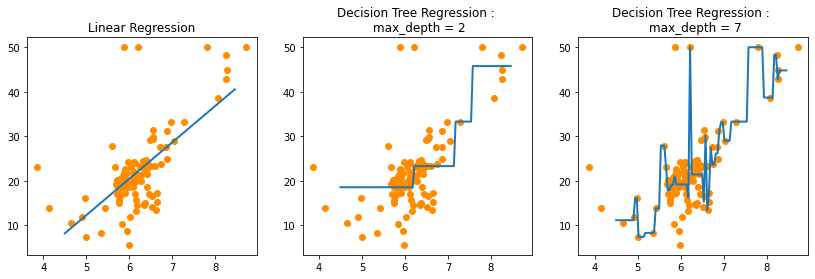

In [43]:
#  LinearRegression과 DecisionTreeRegressor로 학습된 Regressor에서 예측한 PRICE 회귀선 시각화
fig , (ax1, ax2, ax3) = plt.subplots(figsize = (14,4), ncols = 3)

# X축 값을 4.5~8.5로 변환하여 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각환
# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax1.plot(X_test, pred_lr,label = "linear", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax2.plot(X_test, pred_rf2, label = "max_depth : 3", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax3.plot(X_test, pred_rf7, label = "max_depth : 7", linewidth = 2)

- 선형 회귀는 직선으로 예측 회귀선을 가지는 반면, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태의 회귀선 생성
- DecisionTreeRegressor의 max_depth = 7인 경우 과적합이 되기 쉬운 모델